In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import math

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

### Load the dataset

In [2]:
df = pd.read_csv("./data/writing_center.csv")
df.head()

,Student_ID,Term,Section_ID,Instructor_ID,Main_CourseID,Gender,Age,Ethnicity,FirstGen,Military,...,International,Nonresident,WR_Center,Main_Course_SuccessFlag,Main_Course_GradePoints,HS_GPA,Online,N_Center_Visits,Center_Attendance_Hours,N_Conf
0,1,Year 1 Fall,112,9569,ENG 1,Male,21,Mixed Ethnicity,0,0,...,0,0,0,1,2,NaN,1,NaN,NaN,NaN
1,2,Year 1 Fall,89,1515,ENG 1,Female,24,Mixed Ethnicity,0,0,...,0,0,1,0,1,NaN,0,17.0,18.351944,1.0
2,3,Year 1 Fall,99,2357,ENG 1,Female,24,Hispanic / Latino,0,0,...,0,0,0,1,4,2.113,0,NaN,NaN,NaN
3,9,Year 1 Fall,102,1672,ENG 1,Male,24,"White, Non-Hispanic",1,0,...,0,0,0,1,3,2.249,0,NaN,NaN,NaN
4,11,Year 1 Fall,102,1672,ENG 1,Male,26,Asian,1,0,...,0,0,0,1,2,3.100,0,NaN,NaN,NaN


### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727 entries, 0 to 4726
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Student_ID                   4727 non-null   int64  
 1   Term                         4727 non-null   object 
 2   Section_ID                   4727 non-null   int64  
 3   Instructor_ID                4727 non-null   int64  
 4   Main_CourseID                4727 non-null   object 
 5   Gender                       4727 non-null   object 
 6   Age                          4727 non-null   int64  
 7   Ethnicity                    4727 non-null   object 
 8   FirstGen                     4727 non-null   int64  
 9   Military                     4727 non-null   int64  
 10  FosterYouth                  4727 non-null   int64  
 11  DSPS                         4727 non-null   int64  
 12  FinAid                       4727 non-null   int64  
 13  Units_Attempted_Be

##### Check [here](https://cran.r-project.org/web/packages/IRexamples/IRexamples.pdf) to get a detailed description on features

#### Feature Engineering

In [4]:
# add an additional feature called WR_Center_FailFlag (as there are min requirements for WR_Center)
df.loc[(df['WR_Center']==1)&((df['Center_Attendance_Hours']<12)|(df['N_Conf']<2)), 'WR_Center_FailFlag'] = 1
df.loc[(df['WR_Center']==1)&(df['WR_Center_FailFlag'].isnull()), 'WR_Center_FailFlag'] = 0

#### Deal with missing values and etc.

In [5]:
# replace GPA_Beg_Of_Term == 0 with NaN when Units_Attempted_Beg_Of_Term != 0
df.loc[df['Units_Attempted_Beg_Of_Term']==0, 'GPA_Beg_Of_Term'] = df.loc[df['Units_Attempted_Beg_Of_Term']==0, 'GPA_Beg_Of_Term'].replace([0], np.nan)

# add binary features to signal missing values for HS GPA, GPA_Beg_Of_Term (required for future modeling)
df['HS_GPA_Flag'] = df['HS_GPA'].notnull().astype(int)
df['CC_GPA_Flag'] = df['GPA_Beg_Of_Term'].notnull().astype(int)

# replace "Decline" values with NaN
df.loc[df['Gender']=="Decline", 'Gender'] = df.loc[df['Gender']=='Decline', 'Gender'].replace(['Decline'], np.nan)
df.loc[df['Ethnicity']=="Decline to State", 'Ethnicity'] = df.loc[df['Ethnicity']=='Decline to State', 'Ethnicity'].replace(['Decline to State'], np.nan)

<Axes: >

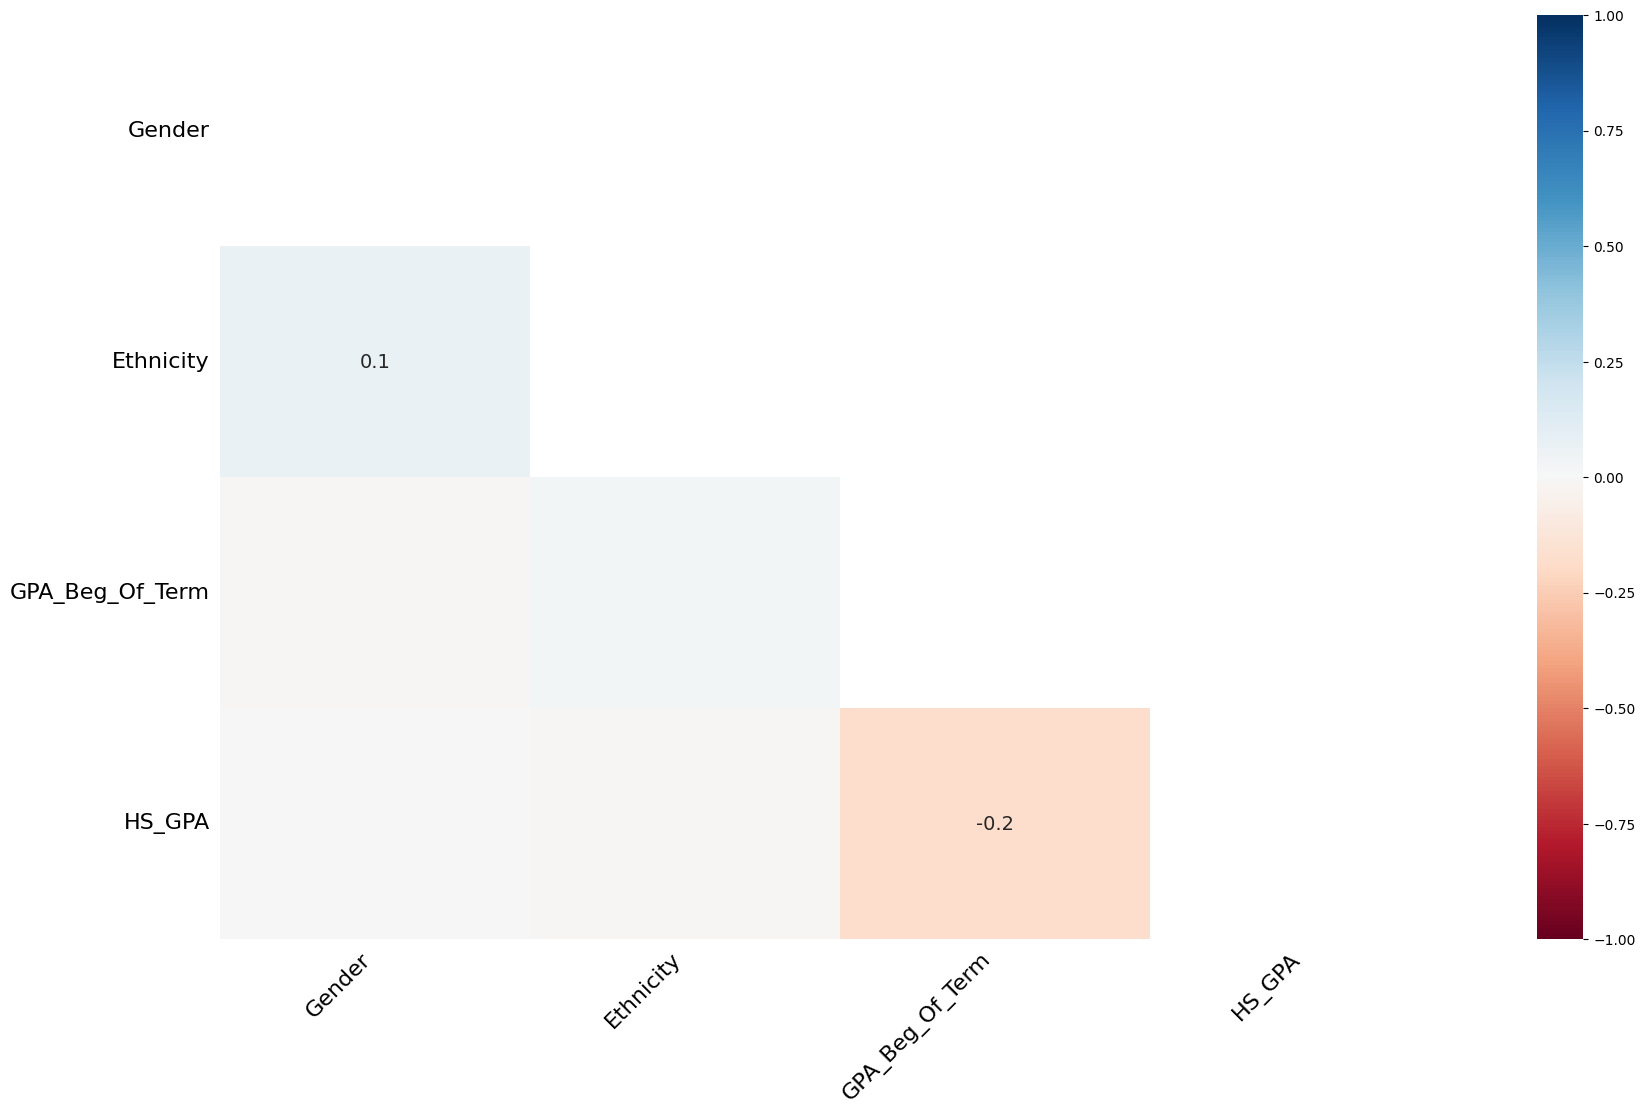

In [6]:
# the missingno correlation heatmap measures nullity correlation
msno.heatmap(df[['Gender', 'Ethnicity', 'GPA_Beg_Of_Term', 'HS_GPA']])

In [7]:
# create a new df for the further analysis with filtering
df_new = df[((df['Gender']=="Male")|(df['Gender']=="Female"))&((df['Ethnicity']=="Asian")|(df['Ethnicity']=="White, Non-Hispanic")|(df['Ethnicity']=="Mixed Ethnicity")|(df['Ethnicity']=="Hispanic / Latino"))]
df_new = pd.get_dummies(df_new, columns=['Gender', 'Ethnicity'], dtype=int)
df_new['N_Center_Visits'].fillna(0, inplace=True)
df_new['Center_Attendance_Hours'].fillna(0, inplace=True)
df_new['N_Conf'].fillna(0, inplace=True)
df_new['WR_Center_FailFlag'].fillna(0, inplace=True)
print(df_new.head())

df_new.to_csv('./data/writing_center_v2.csv')

   Student_ID         Term  Section_ID  Instructor_ID Main_CourseID  Age  \
0           1  Year 1 Fall         112           9569         ENG 1   21   
1           2  Year 1 Fall          89           1515         ENG 1   24   
2           3  Year 1 Fall          99           2357         ENG 1   24   
3           9  Year 1 Fall         102           1672         ENG 1   24   
4          11  Year 1 Fall         102           1672         ENG 1   26   

   FirstGen  Military  FosterYouth  DSPS  ...  N_Conf  WR_Center_FailFlag  \
0         0         0            0     0  ...     0.0                 0.0   
1         0         0            0     0  ...     1.0                 1.0   
2         0         0            0     0  ...     0.0                 0.0   
3         1         0            0     0  ...     0.0                 0.0   
4         1         0            0     0  ...     0.0                 0.0   

   HS_GPA_Flag  CC_GPA_Flag  Gender_Female  Gender_Male  Ethnicity_Asian  \
0   

#### Check the target variable (Main_Course_GradePoints)

count    4727.000000
mean        2.538608
std         1.475337
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: Main_Course_GradePoints, dtype: float64


/var/folders/tj/hl1lt9gs7437b5wxt0r22tfc0000gn/T/ipykernel_86548/2994349575.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Main_Course_GradePoints'], color='g', bins=100, hist_kws={'alpha': 0.4})


<Axes: xlabel='Main_Course_GradePoints', ylabel='Density'>

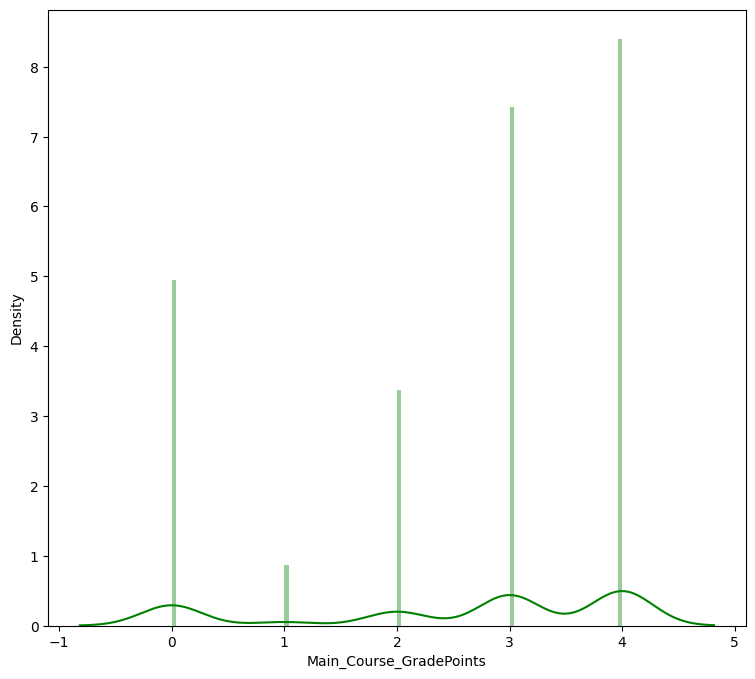

In [8]:
print(df['Main_Course_GradePoints'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['Main_Course_GradePoints'], color='g', bins=100, hist_kws={'alpha': 0.4})

#### Categorical data distribution

In [9]:
list(set(df.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [10]:
df_cat = df.select_dtypes(include = ['O'])
df_cat.head()

,Term,Main_CourseID,Gender,Ethnicity
0,Year 1 Fall,ENG 1,Male,Mixed Ethnicity
1,Year 1 Fall,ENG 1,Female,Mixed Ethnicity
2,Year 1 Fall,ENG 1,Female,Hispanic / Latino
3,Year 1 Fall,ENG 1,Male,"White, Non-Hispanic"
4,Year 1 Fall,ENG 1,Male,Asian


In [11]:
df_cat['Term'].value_counts()

Term
Year 2 Fall      1266
Year 1 Fall      1121
Year 3 Spring    1074
Year 2 Spring     878
Year 2 Summer     218
Year 3 Summer     170
Name: count, dtype: int64

In [12]:
df_cat['Gender'].value_counts()

Gender
Male      2403
Female    2258
Name: count, dtype: int64

In [13]:
df_cat['Ethnicity'].value_counts()

Ethnicity
White, Non-Hispanic    1501
Asian                  1442
Mixed Ethnicity         972
Hispanic / Latino       605
African American         93
Pacific Islander          9
Native American           3
Name: count, dtype: int64

In [14]:
df_cat.groupby('Gender')['Ethnicity'].value_counts()

Gender  Ethnicity          
Female  White, Non-Hispanic    721
        Asian                  666
        Mixed Ethnicity        476
        Hispanic / Latino      300
        African American        48
        Native American          2
        Pacific Islander         1
Male    Asian                  766
        White, Non-Hispanic    756
        Mixed Ethnicity        485
        Hispanic / Latino      293
        African American        43
        Pacific Islander         8
        Native American          1
Name: count, dtype: int64

#### Numerical data distribution

In [15]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Student_ID,Section_ID,Instructor_ID,Age,FirstGen,Military,FosterYouth,DSPS,FinAid,Units_Attempted_Beg_Of_Term,...,Main_Course_SuccessFlag,Main_Course_GradePoints,HS_GPA,Online,N_Center_Visits,Center_Attendance_Hours,N_Conf,WR_Center_FailFlag,HS_GPA_Flag,CC_GPA_Flag
0,1,112,9569,21,0,0,0,0,1,42.0,...,1,2,NaN,1,NaN,NaN,NaN,NaN,0,1
1,2,89,1515,24,0,0,0,0,0,93.5,...,0,1,NaN,0,17.0,18.351944,1.0,1.0,0,1
2,3,99,2357,24,0,0,0,0,1,42.0,...,1,4,2.113,0,NaN,NaN,NaN,NaN,1,1
3,9,102,1672,24,1,0,0,0,0,49.0,...,1,3,2.249,0,NaN,NaN,NaN,NaN,1,1
4,11,102,1672,26,1,0,0,0,0,25.0,...,1,2,3.100,0,NaN,NaN,NaN,NaN,1,1


array([[<Axes: title={'center': 'Student_ID'}>,
        <Axes: title={'center': 'Section_ID'}>,
        <Axes: title={'center': 'Instructor_ID'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'FirstGen'}>],
       [<Axes: title={'center': 'Military'}>,
        <Axes: title={'center': 'FosterYouth'}>,
        <Axes: title={'center': 'DSPS'}>,
        <Axes: title={'center': 'FinAid'}>,
        <Axes: title={'center': 'Units_Attempted_Beg_Of_Term'}>],
       [<Axes: title={'center': 'GPA_Beg_Of_Term'}>,
        <Axes: title={'center': 'TermUnitsAttempted'}>,
        <Axes: title={'center': 'K12_Student'}>,
        <Axes: title={'center': 'First_Time_College_Student'}>,
        <Axes: title={'center': 'Nonresident_Tuition_Exempt'}>],
       [<Axes: title={'center': 'International'}>,
        <Axes: title={'center': 'Nonresident'}>,
        <Axes: title={'center': 'WR_Center'}>,
        <Axes: title={'center': 'Main_Course_SuccessFlag'}>,
        <Axes: title={'

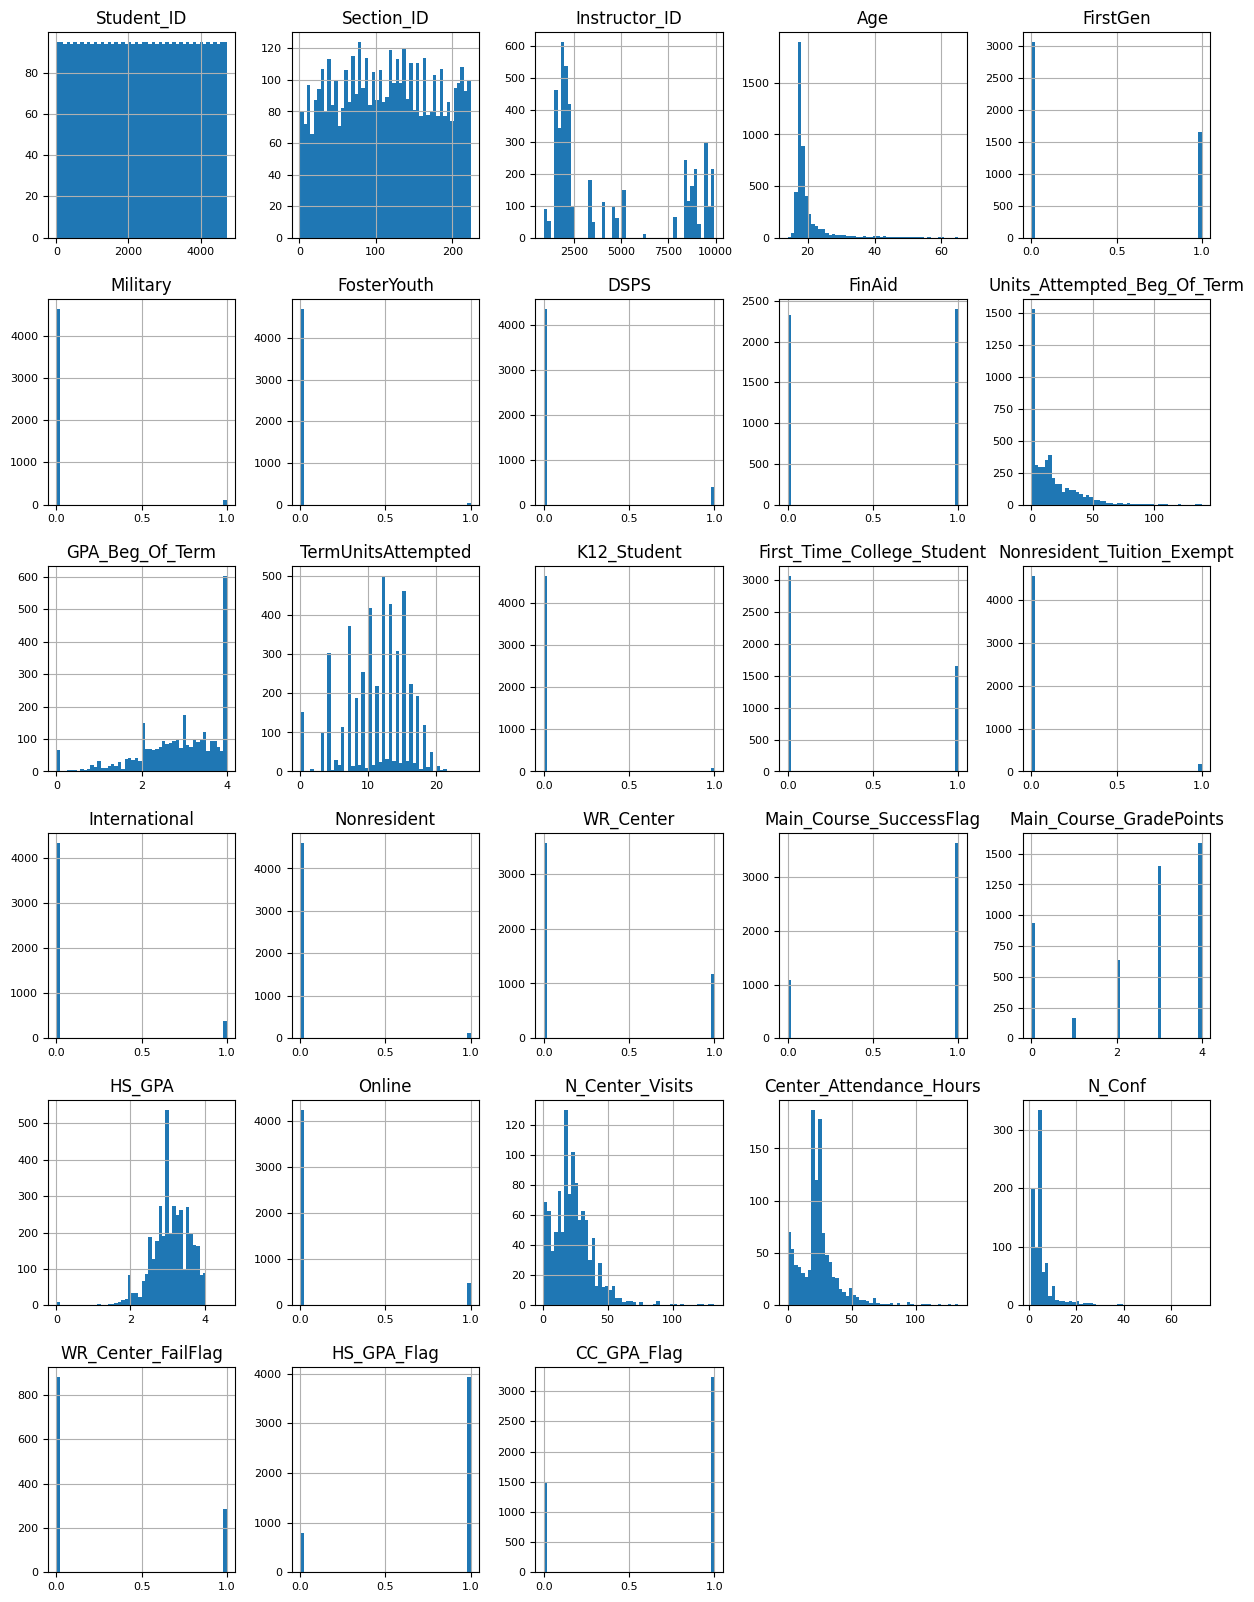

In [16]:
df_num.hist(figsize=(15, 20), bins=50, xlabelsize=8, ylabelsize=8)

#### Check for correlation to the target variable

([0, 1], [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

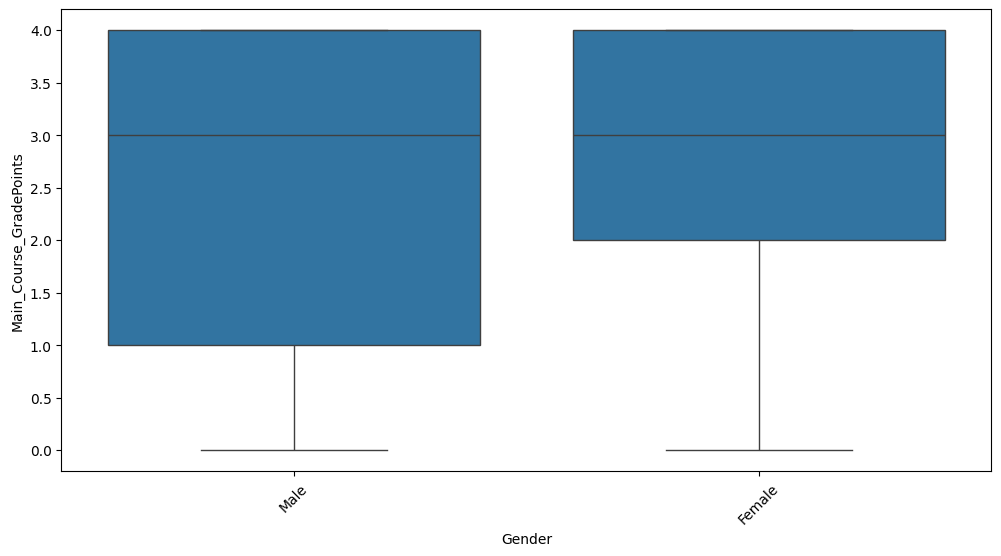

In [17]:
# Main_Course_GradePoints ~ Gender
plt.figure(figsize = (12, 6))
ax = sns.boxplot(x='Gender', y='Main_Course_GradePoints', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Mixed Ethnicity'),
  Text(1, 0, 'White, Non-Hispanic'),
  Text(2, 0, 'Asian'),
  Text(3, 0, 'Hispanic / Latino'),
  Text(4, 0, 'African American')])

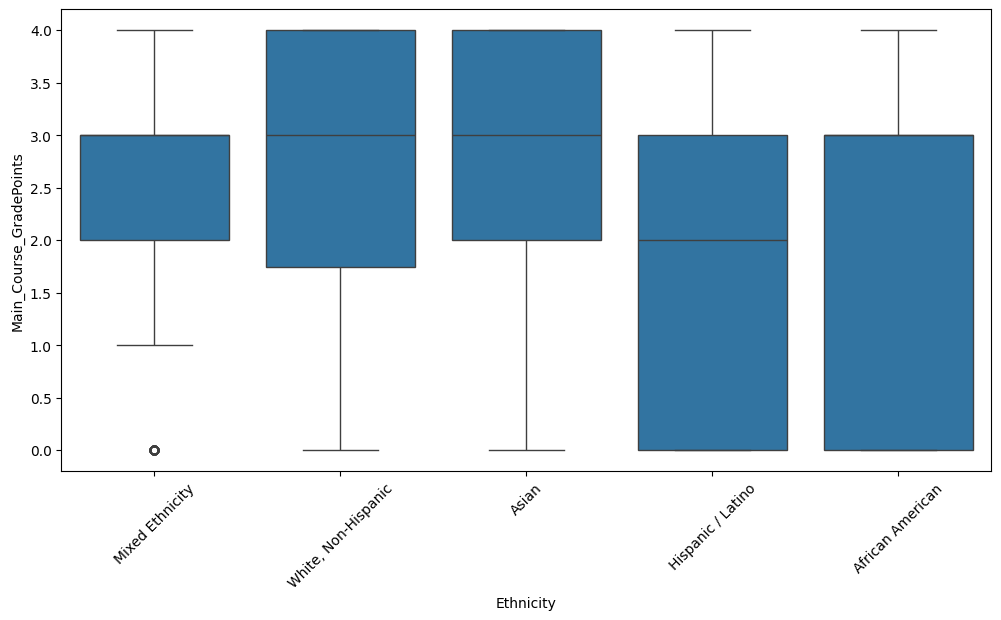

In [18]:
# Main_Course_GradePoints ~ Ethnicity|Gender=Male except for 'Pacific Islander' and 'Native American' (too small of a sample)
plt.figure(figsize = (12, 6))
ax = sns.boxplot(x='Ethnicity', y='Main_Course_GradePoints', data=df[(df['Gender']=='Male')&(df['Ethnicity']!='Pacific Islander')&(df['Ethnicity']!='Native American')])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Mixed Ethnicity'),
  Text(1, 0, 'Hispanic / Latino'),
  Text(2, 0, 'White, Non-Hispanic'),
  Text(3, 0, 'Asian'),
  Text(4, 0, 'African American')])

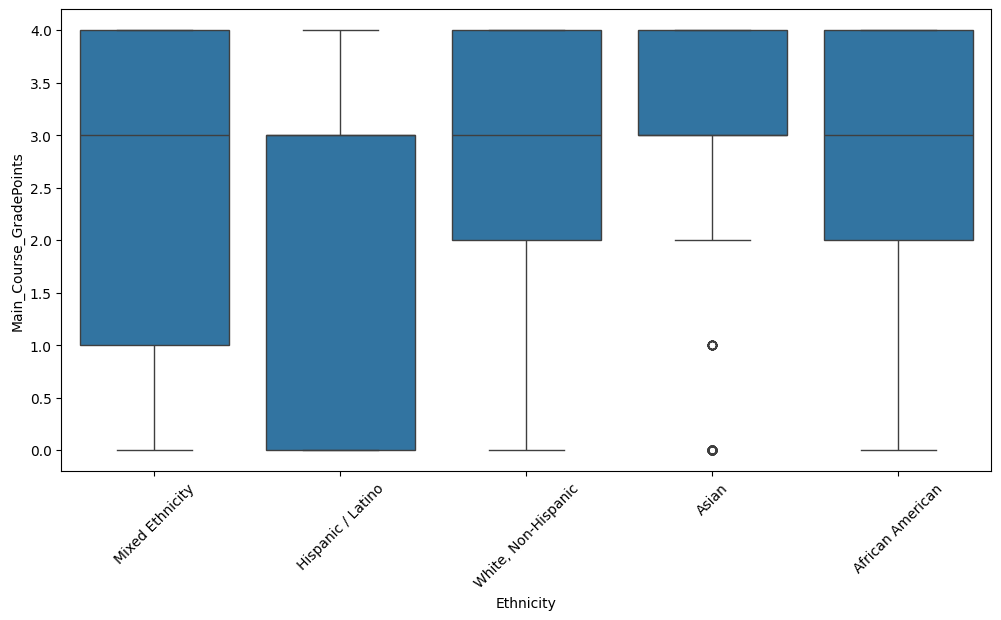

In [19]:
# Main_Course_GradePoints ~ Ethnicity|Gender=Female except for 'Pacific Islander' and 'Native American' (too small of a sample)
plt.figure(figsize = (12, 6))
ax = sns.boxplot(x='Ethnicity', y='Main_Course_GradePoints', data=df[(df['Gender']=='Female')&(df['Ethnicity']!='Pacific Islander')&(df['Ethnicity']!='Native American')])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [20]:
# perform one-hot encodings on Gender and Ethnicity
df_encoded = pd.get_dummies(df, columns=['Gender', 'Ethnicity'], dtype=int)

# update df_num
df_num = df_encoded.select_dtypes(include = ['float64', 'int64'])

In [21]:
df_num_corr = df_num.corr()['Main_Course_GradePoints'] 
golden_features_list_1 = df_num_corr[(abs(df_num_corr) > 0.1)&(abs(df_num_corr) < 0.8)].sort_values(ascending=False) # set (< 0.8) to exclude Main_Course_GradePoints and Main_Course_SuccessFlag 
print("There is {} strongly correlated values with Main_Course_GradePoints:\n{}".format(len(golden_features_list_1), golden_features_list_1))

There is 9 strongly correlated values with Main_Course_GradePoints:
GPA_Beg_Of_Term                0.469882
TermUnitsAttempted             0.429069
Center_Attendance_Hours        0.342344
HS_GPA                         0.338443
N_Center_Visits                0.291246
N_Conf                         0.187581
Ethnicity_Asian                0.129047
Ethnicity_Hispanic / Latino   -0.139449
WR_Center_FailFlag            -0.321736
Name: Main_Course_GradePoints, dtype: float64


In [22]:
df_num_corr = df_num.corr()['Main_Course_SuccessFlag'] 
golden_features_list_2 = df_num_corr[(abs(df_num_corr) > 0.1)&(abs(df_num_corr) < 0.8)].sort_values(ascending=False) # set (< 0.8) to exclude Main_Course_GradePoints and Main_Course_SuccessFlag 
print("There is {} strongly correlated values with Main_Course_SuccessFlag:\n{}".format(len(golden_features_list_2), golden_features_list_2))

There is 9 strongly correlated values with Main_Course_SuccessFlag:
TermUnitsAttempted             0.406989
GPA_Beg_Of_Term                0.378359
Center_Attendance_Hours        0.341486
N_Center_Visits                0.315797
HS_GPA                         0.261088
N_Conf                         0.163344
Ethnicity_Asian                0.104872
Ethnicity_Hispanic / Latino   -0.114641
WR_Center_FailFlag            -0.330438
Name: Main_Course_SuccessFlag, dtype: float64


                         Main_Course_SuccessFlag      Male    Female  \
Main_Course_SuccessFlag                 1.000000 -0.048682  0.048682   
Male                                   -0.048682  1.000000 -1.000000   
Female                                  0.048682 -1.000000  1.000000   
White                                   0.009000 -0.004926  0.004926   
Asian                                   0.103982  0.026913 -0.026913   
Hispanic                               -0.120654 -0.016645  0.016645   
Mixed                                  -0.028757 -0.011180  0.011180   
Age                                     0.000047 -0.092071  0.092071   
FinAid                                 -0.051991 -0.070885  0.070885   
TermUnitsAttempted                      0.412124  0.003171 -0.003171   

                            White     Asian  Hispanic     Mixed       Age  \
Main_Course_SuccessFlag  0.009000  0.103982 -0.120654 -0.028757  0.000047   
Male                    -0.004926  0.026913 -0.016645

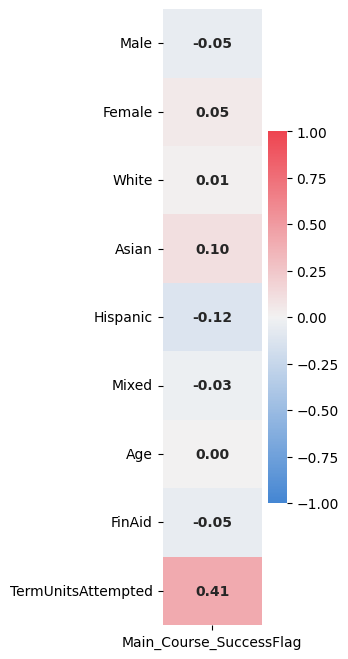

In [23]:
df_new.rename(columns={'Gender_Male': 'Male', 'Gender_Female': 'Female', 'Ethnicity_White, Non-Hispanic': 'White', 'Ethnicity_Asian': 'Asian', 'Ethnicity_Hispanic / Latino': 'Hispanic', 'Ethnicity_Mixed Ethnicity': 'Mixed'}, inplace=True)

target_var = 'Main_Course_SuccessFlag'
explanatory_vars = ['Male', 'Female',
                'White', 'Asian', 'Hispanic', 'Mixed',
                'Age', 'FinAid', 'TermUnitsAttempted']


# Select only the target variable and explanatory variables
selected_vars = [target_var] + explanatory_vars
df_selected = df_new[selected_vars]

# Calculate correlation matrix of the selected variables
corr_matrix_selected = df_selected.corr()

# Print correlation matrix
print(corr_matrix_selected)

plt.figure(figsize=(1.6, 8))  # Adjust size as needed

# Create a custom color map with range -1 to 1
cmap = sns.diverging_palette(250, 10, s=80, l=55, as_cmap=True)

# Create a custom formatter function to round up to 2 decimal places
formatter = lambda x: f'{np.round(x, 2):g}'

sns.heatmap(corr_matrix_selected[[target_var]][1:], annot=True, cmap=cmap, vmin=-1, vmax=1, fmt='.2f', annot_kws={'size': 10, 'fontweight': 'bold'})
plt.savefig("./figures/heatmap.svg", bbox_inches="tight", dpi=120, format='svg')
plt.show()

#### Check for correlation between feature variables

<Axes: >

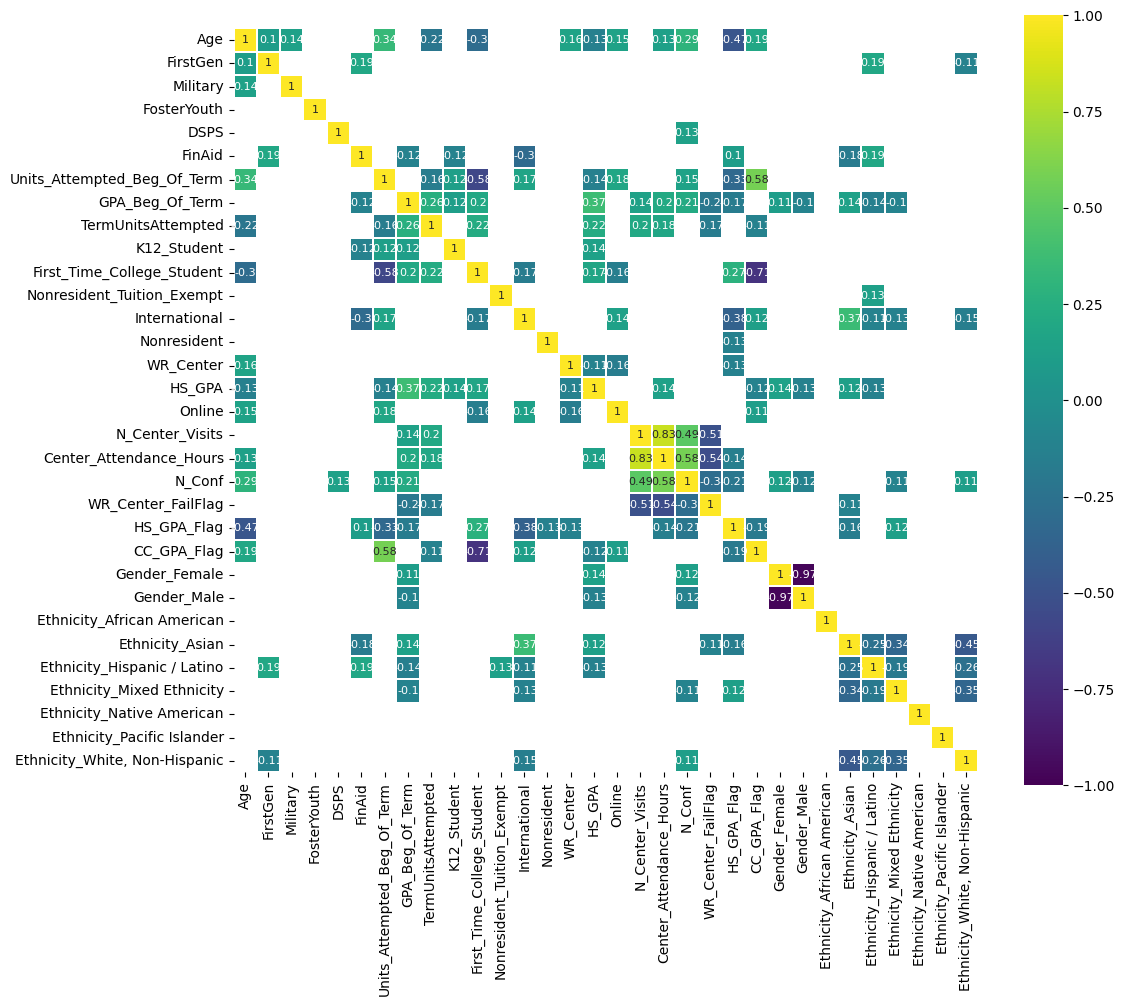

In [24]:
corr = df_num.drop(["Student_ID", "Section_ID", "Instructor_ID", 'Main_Course_GradePoints', 'Main_Course_SuccessFlag'], axis=1).corr() # We already examined Main_Course_GradePoints correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

### Section/Instructor-level analysis

#### Create section-level DF

In [25]:
section_df1 = df.groupby('Section_ID')['Instructor_ID'].value_counts().reset_index()
section_df1.columns = ['Section_ID', 'Instructor_ID', 'N_Students']

section_df2 = df.groupby(['Section_ID', 'Instructor_ID'])['Main_Course_SuccessFlag'].sum().reset_index()
section_df2.columns = ['Section_ID', 'Instructor_ID', 'N_Passed']

section_df3 = df.groupby(['Section_ID', 'Instructor_ID'])['Main_Course_GradePoints'].mean().reset_index()
section_df3.columns = ['Section_ID', 'Instructor_ID', 'AVG_GradePoints']

section_df4 = df.groupby(['Section_ID', 'Instructor_ID'])['Main_Course_GradePoints'].std().reset_index()
section_df4.columns = ['Section_ID', 'Instructor_ID', 'SD_GradePoints']

section_df5 = df_encoded.groupby(['Section_ID', 'Instructor_ID'])['Ethnicity_Asian'].sum().reset_index()
section_df5.columns = ['Section_ID', 'Instructor_ID', 'N_Asian']

section_df6 = df_encoded.groupby(['Section_ID', 'Instructor_ID'])['Ethnicity_Hispanic / Latino'].sum().reset_index()
section_df6.columns = ['Section_ID', 'Instructor_ID', 'N_Hispanic']

section_df7 = df_encoded.groupby(['Section_ID', 'Instructor_ID'])['WR_Center'].sum().reset_index()
section_df7.columns = ['Section_ID', 'Instructor_ID', 'N_WR_Center_Enrolled']

section_df8 = df_encoded.groupby(['Section_ID', 'Instructor_ID'])['WR_Center_FailFlag'].sum().reset_index()
section_df8.columns = ['Section_ID', 'Instructor_ID', 'N_WR_Center_Failed']

section_df9 = df_encoded.groupby(['Section_ID', 'Instructor_ID'])['Gender_Male'].sum().reset_index()
section_df9.columns = ['Section_ID', 'Instructor_ID', 'N_Male']

section_df10 = df_encoded.groupby(['Section_ID', 'Instructor_ID'])['Gender_Female'].sum().reset_index()
section_df10.columns = ['Section_ID', 'Instructor_ID', 'N_Female']

In [26]:
section_df = pd.merge(section_df1, section_df2, on=['Section_ID', 'Instructor_ID'], how='left')
section_df = pd.merge(section_df, section_df3, on=['Section_ID', 'Instructor_ID'], how='left')
section_df = pd.merge(section_df, section_df4, on=['Section_ID', 'Instructor_ID'], how='left')
section_df = pd.merge(section_df, section_df5, on=['Section_ID', 'Instructor_ID'], how='left')
section_df = pd.merge(section_df, section_df6, on=['Section_ID', 'Instructor_ID'], how='left')
section_df = pd.merge(section_df, section_df7, on=['Section_ID', 'Instructor_ID'], how='left')
section_df = pd.merge(section_df, section_df8, on=['Section_ID', 'Instructor_ID'], how='left')
section_df = pd.merge(section_df, section_df9, on=['Section_ID', 'Instructor_ID'], how='left')
section_df = pd.merge(section_df, section_df10, on=['Section_ID', 'Instructor_ID'], how='left')

section_df['Pass_Percent'] = 100 * section_df['N_Passed'] / section_df['N_Students']
section_df['Male_Percent'] = 100 * section_df['N_Male'] / section_df['N_Students']
section_df['Female_Percent'] = 100 * section_df['N_Female'] / section_df['N_Students']
section_df['Asian_Percent'] = 100 * section_df['N_Asian'] / section_df['N_Students']
section_df['Hispanic_Percent'] = 100 * section_df['N_Hispanic'] / section_df['N_Students']
section_df['WR_Enrolled_Percent'] = 100 * section_df['N_WR_Center_Enrolled'] / section_df['N_Students']
section_df['WR_Finished_Percent'] = 100 * (section_df['N_WR_Center_Enrolled'] - section_df['N_WR_Center_Failed']) / section_df['N_WR_Center_Enrolled']
section_df['WR_Finished_Percent'].fillna(100, inplace=True)

section_df['Pass_Percent'] = section_df['Pass_Percent'].apply(math.floor)
section_df['Asian_Percent'] = section_df['Asian_Percent'].apply(math.floor)
section_df['Hispanic_Percent'] = section_df['Hispanic_Percent'].apply(math.floor)
section_df['Male_Percent'] = section_df['Male_Percent'].apply(math.floor)
section_df['Female_Percent'] = section_df['Female_Percent'].apply(math.floor)
section_df['WR_Enrolled_Percent'] = section_df['WR_Enrolled_Percent'].apply(math.floor)
section_df['WR_Finished_Percent'] = section_df['WR_Finished_Percent'].apply(math.floor)

section_df[['N_Students', 'N_Passed', 'AVG_GradePoints', 'SD_GradePoints', 'Pass_Percent', 'Male_Percent', 'Female_Percent', 'Asian_Percent', 'Hispanic_Percent', 'WR_Enrolled_Percent']].describe()

,N_Students,N_Passed,AVG_GradePoints,SD_GradePoints,Pass_Percent,Male_Percent,Female_Percent,Asian_Percent,Hispanic_Percent,WR_Enrolled_Percent
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,21.008889,16.186667,2.525065,1.361979,76.324444,50.515556,47.324444,30.702222,12.462222,24.008889
std,3.703270,4.368189,0.605183,0.262659,14.652419,11.782667,11.636096,14.506625,8.819097,29.316468
min,10.000000,4.000000,0.846154,0.428932,27.000000,20.000000,19.000000,5.000000,0.000000,0.000000
25%,19.000000,13.000000,2.080000,1.215092,68.000000,42.000000,40.000000,20.000000,6.000000,5.000000
50%,21.000000,16.000000,2.541667,1.424574,78.000000,50.000000,47.000000,28.000000,11.000000,14.000000
75%,24.000000,19.000000,3.000000,1.538112,88.000000,58.000000,56.000000,39.000000,18.000000,27.000000
max,33.000000,31.000000,3.772727,2.017778,100.000000,80.000000,76.000000,78.000000,50.000000,100.000000


#### Check section-level Pass_Percent distribution

/var/folders/tj/hl1lt9gs7437b5wxt0r22tfc0000gn/T/ipykernel_86548/2585397983.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(section_df['Pass_Percent'], color='g', bins=100, hist_kws={'alpha': 0.4})


<Axes: xlabel='Pass_Percent', ylabel='Density'>

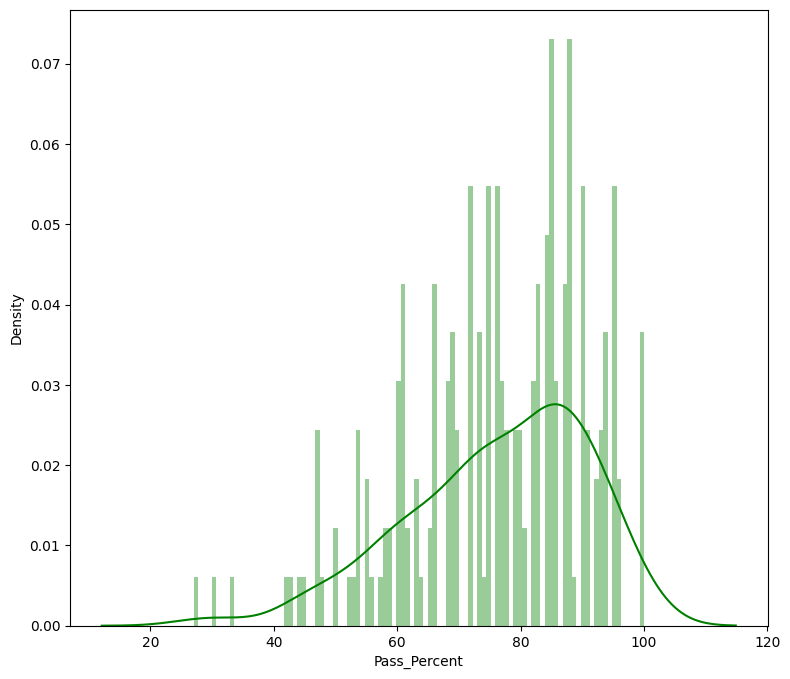

In [27]:
plt.figure(figsize=(9, 8))
sns.distplot(section_df['Pass_Percent'], color='g', bins=100, hist_kws={'alpha': 0.4})

#### Check correlation to the "target" variables

In [28]:
section_df_corr = section_df[['Pass_Percent', 'N_Students', 'Male_Percent', 'Female_Percent', 'Asian_Percent', 'Hispanic_Percent', 'WR_Enrolled_Percent', 'WR_Finished_Percent']].corr()['Pass_Percent'] 
golden_features_list = section_df_corr.sort_values(ascending=False)[1:]
print("Below are the correlation values with Pass_Percent:\n{}".format(golden_features_list))

Below are the correlation values with Pass_Percent:
Asian_Percent          0.252469
Female_Percent         0.159181
N_Students             0.126647
WR_Finished_Percent    0.007263
WR_Enrolled_Percent   -0.047044
Male_Percent          -0.145754
Hispanic_Percent      -0.200540
Name: Pass_Percent, dtype: float64


In [29]:
section_df_corr = section_df[['AVG_GradePoints', 'N_Students', 'Male_Percent', 'Female_Percent', 'Asian_Percent', 'Hispanic_Percent', 'WR_Enrolled_Percent', 'WR_Finished_Percent']].corr()['AVG_GradePoints'] 
golden_features_list = section_df_corr.sort_values(ascending=False)[1:]
print("Below are the correlation values with AVG_GradePoints:\n{}".format(golden_features_list))

Below are the correlation values with AVG_GradePoints:
Asian_Percent          0.313430
Female_Percent         0.212977
N_Students             0.127518
WR_Finished_Percent    0.024715
WR_Enrolled_Percent   -0.105703
Male_Percent          -0.192958
Hispanic_Percent      -0.238170
Name: AVG_GradePoints, dtype: float64


In [30]:
section_df_corr = section_df[['SD_GradePoints', 'N_Students', 'Male_Percent', 'Female_Percent', 'Asian_Percent', 'Hispanic_Percent', 'WR_Enrolled_Percent', 'WR_Finished_Percent']].corr()['SD_GradePoints'] 
golden_features_list = section_df_corr.sort_values(ascending=False)[1:]
print("Below are the correlation values with SD_GradePoints:\n{}".format(golden_features_list))

Below are the correlation values with SD_GradePoints:
Male_Percent           0.122863
Hispanic_Percent       0.111295
WR_Enrolled_Percent   -0.012582
WR_Finished_Percent   -0.031666
N_Students            -0.116165
Female_Percent        -0.127390
Asian_Percent         -0.189273
Name: SD_GradePoints, dtype: float64


#### Create instructor-level DF

In [31]:
instructor_df1 = section_df['Instructor_ID'].value_counts().reset_index()
instructor_df1.columns = ['Instructor_ID', 'N_Terms']

instructor_df2 = section_df.groupby('Instructor_ID')['Pass_Percent'].mean().reset_index()
instructor_df2.columns = ['Instructor_ID', 'AVG_Pass_Percent']

instructor_df3 = section_df.groupby('Instructor_ID')['Pass_Percent'].std().reset_index()
instructor_df3.columns = ['Instructor_ID', 'SD_Pass_Percent']
instructor_df3['SD_Pass_Percent'].fillna(0, inplace=True)

instructor_df4 = section_df.groupby('Instructor_ID')['AVG_GradePoints'].mean().reset_index()
instructor_df4.columns = ['Instructor_ID', 'AVG_GradePoints']

instructor_df5 = section_df.groupby('Instructor_ID')['AVG_GradePoints'].std().reset_index()
instructor_df5.columns = ['Instructor_ID', 'SD_GradePoints']
instructor_df5['SD_GradePoints'].fillna(0, inplace=True)

instructor_df6 = section_df.groupby('Instructor_ID')['N_Students'].mean().reset_index()
instructor_df6.columns = ['Instructor_ID', 'AVG_N_Students']

instructor_df7 = section_df.groupby('Instructor_ID')['N_Students'].std().reset_index()
instructor_df7.columns = ['Instructor_ID', 'SD_N_Students']
instructor_df7['SD_N_Students'].fillna(0, inplace=True)

instructor_df8 = section_df.groupby('Instructor_ID')['Male_Percent'].mean().reset_index()
instructor_df8.columns = ['Instructor_ID', 'AVG_Male_Percent']

instructor_df9 = section_df.groupby('Instructor_ID')['Male_Percent'].std().reset_index()
instructor_df9.columns = ['Instructor_ID', 'SD_Male_Percent']
instructor_df9['SD_Male_Percent'].fillna(0, inplace=True)

instructor_df10 = section_df.groupby('Instructor_ID')['Female_Percent'].mean().reset_index()
instructor_df10.columns = ['Instructor_ID', 'AVG_Female_Percent']

instructor_df11 = section_df.groupby('Instructor_ID')['Female_Percent'].std().reset_index()
instructor_df11.columns = ['Instructor_ID', 'SD_Female_Percent']
instructor_df11['SD_Female_Percent'].fillna(0, inplace=True)

instructor_df12 = section_df.groupby('Instructor_ID')['Asian_Percent'].mean().reset_index()
instructor_df12.columns = ['Instructor_ID', 'AVG_Asian_Percent']

instructor_df13 = section_df.groupby('Instructor_ID')['Asian_Percent'].std().reset_index()
instructor_df13.columns = ['Instructor_ID', 'SD_Asian_Percent']
instructor_df13['SD_Asian_Percent'].fillna(0, inplace=True)

instructor_df14 = section_df.groupby('Instructor_ID')['Hispanic_Percent'].mean().reset_index()
instructor_df14.columns = ['Instructor_ID', 'AVG_Hispanic_Percent']

instructor_df15 = section_df.groupby('Instructor_ID')['Hispanic_Percent'].std().reset_index()
instructor_df15.columns = ['Instructor_ID', 'SD_Hispanic_Percent']
instructor_df15['SD_Hispanic_Percent'].fillna(0, inplace=True)

In [32]:
instructor_df = pd.merge(instructor_df1, instructor_df2, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df3, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df4, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df5, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df6, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df7, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df8, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df9, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df10, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df11, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df12, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df13, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df14, on=['Instructor_ID'], how='left')
instructor_df = pd.merge(instructor_df, instructor_df15, on=['Instructor_ID'], how='left')

instructor_df.describe()

,Instructor_ID,N_Terms,AVG_Pass_Percent,SD_Pass_Percent,AVG_GradePoints,SD_GradePoints,AVG_N_Students,SD_N_Students,AVG_Male_Percent,SD_Male_Percent,AVG_Female_Percent,SD_Female_Percent,AVG_Asian_Percent,SD_Asian_Percent,AVG_Hispanic_Percent,SD_Hispanic_Percent
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,4369.903846,4.326923,75.455638,7.778352,2.493545,0.272252,21.226687,2.316586,50.625441,7.436119,46.932090,7.513217,29.979866,10.072753,12.266053,5.609950
std,3157.638670,2.847229,11.231394,6.292477,0.517473,0.201732,3.124870,1.714273,8.532618,5.528492,8.305782,5.494912,9.006583,6.446920,5.051624,4.078192
min,910.000000,1.000000,45.500000,0.000000,1.476667,0.000000,12.000000,0.000000,30.000000,0.000000,27.000000,0.000000,15.000000,0.000000,0.000000,0.000000
25%,1973.250000,2.000000,69.000000,1.587713,2.115812,0.074246,19.775000,0.707107,45.725000,1.853553,41.375000,2.644841,23.635714,5.889960,8.875000,2.828427
50%,2354.000000,4.000000,75.125000,7.191664,2.502171,0.293099,20.875000,2.247510,50.000000,7.758736,47.666667,7.792078,26.833333,11.589905,11.701299,5.571846
75%,8458.250000,6.250000,83.770833,12.588428,2.833965,0.427767,22.446429,3.517797,55.031250,11.189838,51.850000,11.302690,35.041667,15.005195,15.785714,8.000755
max,9935.000000,11.000000,93.000000,24.744408,3.454545,0.759651,33.000000,5.500000,72.000000,17.195930,69.000000,18.384776,55.000000,21.171634,23.000000,15.261608


#### Check instructor-level Pass_Percent distribution

/var/folders/tj/hl1lt9gs7437b5wxt0r22tfc0000gn/T/ipykernel_86548/54660656.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(instructor_df['AVG_Pass_Percent'], color='g', bins=100, hist_kws={'alpha': 0.4})


<Axes: xlabel='AVG_Pass_Percent', ylabel='Density'>

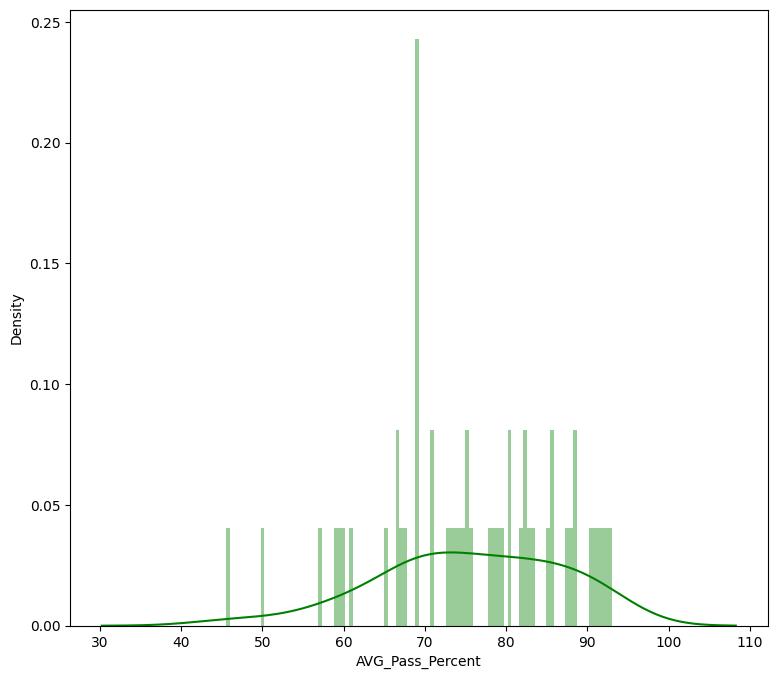

In [33]:
plt.figure(figsize=(9, 8))
sns.distplot(instructor_df['AVG_Pass_Percent'], color='g', bins=100, hist_kws={'alpha': 0.4})

#### Check correlation to the "target" variables in instructor-level

In [34]:
instructor_df_corr = instructor_df[['AVG_Pass_Percent', 'N_Terms', 'AVG_N_Students', 'AVG_Male_Percent', 'AVG_Female_Percent', 'AVG_Asian_Percent', 'AVG_Hispanic_Percent']].corr()['AVG_Pass_Percent'] 
golden_features_list = instructor_df_corr.sort_values(ascending=False)[1:]
print("Below are the correlation values with AVG_Pass_Percent:\n{}".format(golden_features_list))

Below are the correlation values with AVG_Pass_Percent:
AVG_Asian_Percent       0.374705
AVG_Female_Percent      0.255984
AVG_N_Students          0.254235
N_Terms                 0.119861
AVG_Male_Percent       -0.192299
AVG_Hispanic_Percent   -0.246298
Name: AVG_Pass_Percent, dtype: float64


In [35]:
instructor_df_corr = instructor_df[['AVG_GradePoints', 'N_Terms', 'AVG_N_Students', 'AVG_Male_Percent', 'AVG_Female_Percent', 'AVG_Asian_Percent', 'AVG_Hispanic_Percent']].corr()['AVG_GradePoints'] 
golden_features_list = instructor_df_corr.sort_values(ascending=False)[1:]
print("Below are the correlation values with AVG_GradePoints:\n{}".format(golden_features_list))

Below are the correlation values with AVG_GradePoints:
AVG_Asian_Percent       0.435033
AVG_Female_Percent      0.313820
AVG_N_Students          0.288653
N_Terms                 0.094382
AVG_Hispanic_Percent   -0.255506
AVG_Male_Percent       -0.258296
Name: AVG_GradePoints, dtype: float64


In [36]:
instructor_df_corr = instructor_df.loc[instructor_df['N_Terms']>1, ['SD_Pass_Percent', 'N_Terms', 'SD_N_Students', 'SD_Male_Percent', 'SD_Female_Percent', 'SD_Asian_Percent', 'SD_Hispanic_Percent']].corr()['SD_Pass_Percent'] 
golden_features_list = instructor_df_corr.sort_values(ascending=False)[1:]
print("Below are the correlation values with SD_Pass_Percent:\n{}".format(golden_features_list))

Below are the correlation values with SD_Pass_Percent:
SD_N_Students          0.448667
SD_Hispanic_Percent    0.440617
N_Terms                0.420897
SD_Female_Percent      0.296578
SD_Male_Percent        0.285840
SD_Asian_Percent      -0.168976
Name: SD_Pass_Percent, dtype: float64


In [37]:
instructor_df_corr = instructor_df.loc[instructor_df['N_Terms']>1, ['SD_GradePoints', 'N_Terms', 'SD_N_Students', 'SD_Male_Percent', 'SD_Female_Percent', 'SD_Asian_Percent', 'SD_Hispanic_Percent']].corr()['SD_GradePoints'] 
golden_features_list = instructor_df_corr.sort_values(ascending=False)[1:]
print("Below are the correlation values with SD_GradePoints:\n{}".format(golden_features_list))

Below are the correlation values with SD_GradePoints:
SD_Hispanic_Percent    0.462719
N_Terms                0.449867
SD_N_Students          0.399138
SD_Female_Percent      0.282974
SD_Male_Percent        0.270548
SD_Asian_Percent      -0.059788
Name: SD_GradePoints, dtype: float64
